In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

In [2]:
## Function for getting the indeces of the array *arr* between the *var_min* and *var_max* values:
def getRangeIndexes(arr, var_min, var_max):
    return np.where((np.array(arr) >= var_min) & (np.array(arr) <= var_max))[0]

## Function for getting the index of the array for the value ##
def getIndexes(arr, value):
    return np.where(arr = value)

## Function for moving average ##
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## -- Function for get strings of dates in .nc input files -- ##
def set_string_time(file, tname):
    nctime = file.variables[tname][:] # get values
    t_unit = file.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
    t_cal = file.variables[tname].calendar
    tvalue = nc.num2date(nctime,units = t_unit,calendar = t_cal)
    str_time = [i.strftime("%Y-%m") for i in tvalue]
    str_timey = [i.strftime("%Y") for i in tvalue]
    str_timem = [i.strftime("%m") for i in tvalue]
    return [str_time, str_timey, str_timem]

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def detrend_dim(da, dim, degree):
    # Store original attributes
    original_attrs = da.attrs

    # Detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = da - fit
    
    # Restore original attributes
    da_det.attrs = original_attrs
    
    return da_det

## Open SST data

In [3]:
##### ------- Open data (MODEL) ------- #####
data_path = 'C:/Users/mastr/Documents/Amazon'
scenario = 'historical'
files = "nino34" + '_*_' + scenario + '_*'

files_list = []; esm = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # List of files sorted by name
        esm.append(filepath.split("_")[1])
        content = nc.Dataset(filepath)
        files_list.append(content)   

nino34_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_hist.append(content)

scenario = 'ssp585'
files = "nino34" + '_*_' + scenario + '_*' 

nino34_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_ssp.append(content)

# Standardize calendar 
# for i, item in enumerate(nino34_hist):
#     if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
#         nino34_hist[i]['time'] = item.indexes['time'].to_datetimeindex()
    
# for i, item in enumerate(nino34_ssp):
#     if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
#         nino34_ssp[i]['time'] = item.indexes['time'].to_datetimeindex()

## Normalization
for i,item in enumerate(nino34_hist):
    nino34_hist[i] =  ((nino34_hist[i] - (nino34_hist[i].mean(dim='time'))).compute()/(nino34_hist[i].std(dim='time'))).compute()

for i,item in enumerate(nino34_ssp):
    nino34_ssp[i] =  ((nino34_ssp[i] - (nino34_ssp[i].mean(dim='time'))).compute()/(nino34_ssp[i].std(dim='time'))).compute()


# Detrending of 1st order
nino34_hist = [detrend_dim(a.tos, "time", 1) for a in nino34_hist]
nino34_ssp = [detrend_dim(a.tos, "time", 1) for a in nino34_ssp]

## Resample from Monthly to seasonal timesteps
nino34_hist_seas = []
for i,item in enumerate(nino34_hist):
    content = item.resample(time="QS", label='left').mean()
    nino34_hist_seas.append(content)

nino34_ssp_seas = []
for i,item in enumerate(nino34_ssp):
    content = item.resample(time="QS", label='left').mean()
    nino34_ssp_seas.append(content)

In [4]:
for i, item in enumerate(reversed(esm)):
    if item in {"BCC-CSM2-MR","E3SM-1-1-ECA","TaiESM1","NorESM2-MM"}:
        del nino34_hist_seas[i]
        del nino34_ssp_seas[i]

## Open LAND data

In [6]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_historical_'  + '*.nc' 


files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_hist.append(content)

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CESM2-WACCM":
        ds_hist[i] = ds_hist[i]*-1
        ds_hist[i] = ds_hist[i].assign_attrs(esm = files_list[i].source_id)

##### ------- UNIFORM CALENDAR ------- #####
for i, item in enumerate(ds_hist):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist[i]['time'] = item.indexes['time'].to_datetimeindex()

# -- Resample from Months to Seasons
ds_hist_seas = []
for i,item in enumerate(ds_hist):
    content = item.resample(time="QS", label='left').mean()
    ds_hist_seas.append(content)

ds_hist_seas = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_seas]

In [7]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'nep'
files = var_name + '_*_ssp585_'  + '*.nc' 


files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_ssp.append(content)

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CESM2-WACCM":
        ds_ssp[i] = ds_ssp[i]*-1
        ds_ssp[i] = ds_ssp[i].assign_attrs(esm = files_list[i].source_id)

##### ------- UNIFORM CALENDAR ------- #####
for i, item in enumerate(ds_ssp):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp[i]['time'] = item.indexes['time'].to_datetimeindex()

# -- Resample from Months to Seasons
ds_ssp_seas = []
for i,item in enumerate(ds_ssp):
    content = item.resample(time="QS", label='left').mean()
    ds_ssp_seas.append(content)

ds_ssp_seas = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_seas]

#### RAD simulations (net)

In [36]:
scenario = 'ssp585-rad'
files = var_name + '_*_ssp585_'  + '*_net.nc' 

ds_ssp_net = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_net.append(content)                                                                 

##### ------- UNIFORM CALENDAR ------- #####
for i, item in enumerate(ds_ssp_net):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_net[i]['time'] = item.indexes['time'].to_datetimeindex()

# -- Resample from Months to Seasons
ds_ssp_net_seas = []
for i,item in enumerate(ds_ssp_net):
    content = item.resample(time="QS", label='left').mean()
    ds_ssp_net_seas.append(content)
    
# ds_ssp_net_seas = []
# for i, item in enumerate(ds_ssp_net):
#     content = item.rolling(time = 6).mean()                # Compute 7 months running mean
#     content1 = content[content.time.dt.month == 3]     # Select March to get the average over SONDJFM
#     ds_ssp_net_seas.append(content1)

# CanESM5 hist and ssp have numeric values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(ds_ssp_net_seas):
    if ds_ssp_net_seas[i].esm == "CanESM5":
        ds_ssp_net_seas[i] = ds_ssp_net_seas[i].where(ds_ssp_net_seas[i] != -3.7270379e-07)
        ds_ssp_net_seas[i] = ds_ssp_net_seas[i].where(ds_ssp_net_seas[i] != -6.18386321e-06)

In [39]:
scenario = 'historical-rad'
files = var_name + '_*_historical_'  + '*_net.nc' 

ds_hist_net = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_hist_net.append(content)                                                                 

##### ------- UNIFORM CALENDAR ------- #####
for i, item in enumerate(ds_hist_net):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_net[i]['time'] = item.indexes['time'].to_datetimeindex()

# -- Resample from Months to Seasons
ds_hist_net_seas = []
for i,item in enumerate(ds_hist_net):
    content = item.resample(time="QS", label='left').mean()
    ds_hist_net_seas.append(content)
    
# ds_hist_net_seas = []
# for i, item in enumerate(ds_hist_net):
#     content = item.rolling(time = 6).mean()                # Compute 7 months running mean
#     content1 = content[content.time.dt.month == 3]     # Select March to get the average over SONDJFM
#     ds_hist_net_seas.append(content1)

# CanESM5 hist and hist have numeric values of ocean equal to 
# hist: -9.304011e-07
# hist: -1.120609e-05

for i, item in enumerate(ds_hist_net_seas):
    if ds_hist_net_seas[i].esm == "CanESM5":
        ds_hist_net_seas[i] = ds_hist_net_seas[i].where(ds_hist_net_seas[i] != -3.7270379e-07)
        ds_hist_net_seas[i] = ds_hist_net_seas[i].where(ds_hist_net_seas[i] != -6.18386321e-06)

#### Fertilization effect

In [10]:
scenario = 'ssp585-rad'
files = var_name + '_*_ssp585_'  + '*_eco2.nc' 

ds_ssp_eco2 = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_eco2.append(content)                                                                 

##### ------- UNIFORM CALENDAR ------- #####
for i, item in enumerate(ds_ssp_eco2):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_eco2[i]['time'] = item.indexes['time'].to_datetimeindex()

# -- Resample from Months to Seasons
ds_ssp_eco2_seas = []
for i,item in enumerate(ds_ssp_eco2):
    content = item.resample(time="QS", label='left').mean()
    ds_ssp_eco2_seas.append(content)
    
# ds_ssp_eco2_seas = []
# for i, item in enumerate(ds_ssp_eco2):
#     content = item.rolling(time = 6).mean()                # Compute 7 months running mean
#     content1 = content[content.time.dt.month == 3]     # Select March to get the average over SONDJFM
#     ds_ssp_eco2_seas.append(content1)

# CanESM5 hist and ssp have numeric values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(ds_ssp_eco2_seas):
    if ds_ssp_eco2_seas[i].esm == "CanESM5":
        ds_ssp_eco2_seas[i] = ds_ssp_eco2_seas[i].where(ds_ssp_eco2_seas[i] != -3.7270379e-07)
        ds_ssp_eco2_seas[i] = ds_ssp_eco2_seas[i].where(ds_ssp_eco2_seas[i] != -6.18386321e-06)

In [11]:
ds_hist_seas = [item for item in ds_hist_seas if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_ssp_seas = [item for item in ds_ssp_seas if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]

In [12]:
esm = []
for i, item in enumerate(ds_hist_seas):
    esm.append(item.esm)

## Composites analysis

Define Nino events as those DJF seasons lying above 90th perc\
Define Nina events as those DJF seasons lying below 10th perc\
Define Mean State conditions as those DJF seasons in between

Percentiles calculated in the historical scenario (1901-1960) and in the ssp scenario (2040-2100) so that to have the same number of events\

Historical and Future Anomalies are computed with respect to the 1901-1960 and 2041-2100 climatologies respectively (these calculated excluding ENSO events of high magnitude (Nino and Nina events)). \
ENSO effect is computed considering the difference between the Future DJF anomalies with respect to the Historical DJF anomalies.\
MEAN STATE CHANGE is computed considering the difference between Future NEUTRAL conditions and Historical NEUTRAL conditions

In [13]:
seas = "DJF"

def composite_analysis(ds, ds_sst, quant1, quant2, time_init, time_end):
    perc90 = ds_sst.sel(time = ds_sst.time.dt.season==seas).sel(time = slice(time_init,time_end)).quantile(quant1, dim = 'time')      # Percentile only from the DJF season
    perc10 = ds_sst.sel(time = ds_sst.time.dt.season==seas).sel(time = slice(time_init,time_end)).quantile(quant2, dim = 'time')
    # perc90 = ds_sst.sel(time = slice(time_init,time_end)).quantile(quant1, dim = 'time')      # Percentile only from the SONDJFM season
    # perc10 = ds_sst.sel(time = slice(time_init,time_end)).quantile(quant2, dim = 'time')
    nino_events = ds.sel(time = ds.time.dt.season==seas).sel(time = slice(time_init,time_end)).where(ds_sst > perc90, drop=True)
    nina_events = ds.sel(time = ds.time.dt.season==seas).sel(time = slice(time_init,time_end)).where(ds_sst < perc10, drop=True)
    # nino_events = ds.sel(time = slice(time_init,time_end)).where(ds_sst > perc90, drop=True)
    # nina_events = ds.sel(time = slice(time_init,time_end)).where(ds_sst < perc10, drop=True)
    ds_nino = ds.sel(time = nino_events.time, method ="nearest").sel(time = slice(time_init,time_end))  
    ds_nina = ds.sel(time = nina_events.time, method ="nearest").sel(time = slice(time_init,time_end))          
    ds_nino = ds_nino.mean(dim = "time")        # Composites of El Nino
    ds_nina = ds_nina.mean(dim = "time")        # Composites of La Nina
    content = ds.sel(time = ds.time.dt.season==seas).sel(time=slice(time_init,time_end))
    # content = ds.sel(time=slice(time_init,time_end))
    content1 = nino_events.groupby(nino_events.time.dt.year).mean("time")  # NINO events between 1901 an6 1910
    content2 = nina_events.groupby(nina_events.time.dt.year).mean("time")  # NINO events between 1901 an6 1910
    for ninoyrs in np.array(content1.year):                                                                            # drop NINO events'years recursively
        content = content.where(content.time.dt.year != ninoyrs, drop = True)
    for ninayrs in np.array(content2.year):
        content = content.where(content.time.dt.year != ninayrs, drop = True)                                          # drop NINO events'years recursively   
    ds_clim_neutral = content.mean(dim="time")  # Composites of mean state changes (Neutral years)

    ds_nino = ds_nino.assign_attrs(esm = ds.esm)
    ds_nina = ds_nina.assign_attrs(esm = ds.esm)
    ds_clim_neutral = ds_clim_neutral.assign_attrs(esm = ds.esm)
    return ds_clim_neutral, ds_nino, ds_nina

results_hist = [composite_analysis(a, b, 0.9, 0.1, "1901", "1960") for a,b in zip(ds_hist_seas, nino34_hist_seas)]
ds_clim_neutral_hist_nep = [result[0] for result in results_hist]
ds_nino_hist_nep = [result[1] for result in results_hist]
ds_nina_hist_nep = [result[2] for result in results_hist]

results_ssp = [composite_analysis(a, b, 0.9, 0.1, "2041", "2100") for a,b in zip(ds_ssp_seas, nino34_ssp_seas)]
ds_clim_neutral_ssp_nep = [result[0] for result in results_ssp]
ds_nino_ssp_nep = [result[1] for result in results_ssp]
ds_nina_ssp_nep = [result[2] for result in results_ssp]

results_eco2 = [composite_analysis(a, b, 0.9, 0.1, "2041", "2100") for a,b in zip(ds_ssp_net_seas, nino34_ssp_seas)]
ds_clim_neutral_ssp_nep_net = [result[0] for result in results_eco2]

# For MannWhitneyU calculation, the significance is calculated among a composite for SSP (eg (time=12,lon=30,lat=37)) and HIST (eg (time=5,lon=30,lat=37))
# For Anomalies calculation , the anomalies are calculated among the average of those SSP and HIST samples.
# As a consequence, in the code above we need to take the mean along time dimension of the followings:
##  ds_ssp_seas_clim_allseason
##  ds_ssp_seas_clim_nonino
##  ds_ssp_seas_clim_nino

## -- NINO HISTORICAL ANOMALIES
nino_anom_hist = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(ds_nino_hist_nep, ds_clim_neutral_hist_nep)]

## -- NINO SSP585 ANOMALIES
nino_anom_ssp = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(ds_nino_ssp_nep, ds_clim_neutral_ssp_nep)]

## -- NINO EFFECT (considering the difference between anomalies)
nino_effect = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(nino_anom_ssp, nino_anom_hist)]

## -- NINA HISTORICAL ANOMALIES
nina_anom_hist = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(ds_nina_hist_nep, ds_clim_neutral_hist_nep)]

## -- NINA SSP585 ANOMALIES
nina_anom_ssp = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(ds_nina_ssp_nep, ds_clim_neutral_ssp_nep)]

## -- NINA EFFECT (considering the difference between anomalies)
nina_effect = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(nina_anom_ssp, nina_anom_hist)]

## -- MEAN STATE CHANGE
msc_tot = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(ds_clim_neutral_ssp_nep, ds_clim_neutral_hist_nep)]

## -- eCO2
msc_net = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(ds_clim_neutral_ssp_nep_net, ds_clim_neutral_hist_nep)]

## -- MSC_eco2
msc_eco2 = [(a - b).compute(dim=var_name).assign_attrs(esm = a.esm) for a,b in zip(msc_tot, msc_net)]


## -- Save and export Composites list data
# import pickle

# data_path = 'C:/Users/mastr/Documents/Amazon'

# with open(os.path.join(data_path+"/analysis/Composites_"+var_name+"_"+"nino_anom_hist"), "wb") as fp:   #Pickling
#     pickle.dump(nino_anom_hist, fp)

# with open(os.path.join(data_path+"/analysis/Composites_"+var_name+"_"+"nino_anom_ssp"), "wb") as fp:   #Pickling
#     pickle.dump(nino_anom_ssp, fp)

# with open(os.path.join(data_path+"/analysis/Composites_"+var_name+"_"+"nino_effect"), "wb") as fp:   #Pickling
#     pickle.dump(nino_effect, fp)

# with open(os.path.join(data_path+"/analysis/Composites_"+var_name+"_"+"nina_anom_hist"), "wb") as fp:   #Pickling
#     pickle.dump(nina_anom_hist, fp)

# with open(os.path.join(data_path+"/analysis/Composites_"+var_name+"_"+"nina_anom_ssp"), "wb") as fp:   #Pickling
#     pickle.dump(nina_anom_ssp, fp)

# with open(os.path.join(data_path+"/analysis/Composites_"+var_name+"_"+"nina_effect"), "wb") as fp:   #Pickling
#     pickle.dump(nina_effect, fp)

# with open(os.path.join(data_path+"/analysis/Composites_"+var_name+"_"+"msc"), "wb") as fp:   #Pickling
#     pickle.dump(msc, fp)

### Load Mann-Whitney data

In [22]:
#### --------- Load Mann-Whitney list data --------- ####
data_path = 'C:/Users/mastr/Documents/Amazon'

import pickle

with open(os.path.join(data_path+"/analysis/MannWhitney_"+var_name+"_"+"msc_net_fdr"), "rb") as fp:   #Pickling
    mannwhitney_msc = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/MannWhitney_"+var_name+"_"+"nino_effect_fdr"), "rb") as fp:   #Pickling
    mannwhitney_nino_effect = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/MannWhitney_"+var_name+"_"+"nina_effect_fdr"), "rb") as fp:   #Pickling
    mannwhitney_nina_effect = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/MannWhitney_"+var_name+"_"+"nino_anom_hist_fdr"), "rb") as fp:   #Pickling
    mannwhitney_nino_anom_hist = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/MannWhitney_"+var_name+"_"+"nina_anom_hist_fdr"), "rb") as fp:   #Pickling
    mannwhitney_nina_anom_hist = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/MannWhitney_"+var_name+"_"+"nino_anom_ssp_fdr"), "rb") as fp:   #Pickling
    mannwhitney_nino_anom_ssp = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/MannWhitney_"+var_name+"_"+"nina_anom_ssp_fdr"), "rb") as fp:   #Pickling
    mannwhitney_nina_anom_ssp = pickle.load(fp)


In [23]:
# Convert numpy array to xarray

mannwhitney_nino_effect = [xr.DataArray(a[1], dims=('lat', 'lon')) for a in mannwhitney_nino_effect]
mannwhitney_nina_effect = [xr.DataArray(a[1], dims=('lat', 'lon')) for a in mannwhitney_nina_effect]
mannwhitney_msc = [xr.DataArray(a[1], dims=('lat', 'lon')) for a in mannwhitney_msc]
mannwhitney_nino_anom_hist = [xr.DataArray(a[1], dims=('lat', 'lon')) for a in mannwhitney_nino_anom_hist]
mannwhitney_nino_anom_ssp = [xr.DataArray(a[1], dims=('lat', 'lon')) for a in mannwhitney_nino_anom_ssp]
mannwhitney_nina_anom_hist = [xr.DataArray(a[1], dims=('lat', 'lon')) for a in mannwhitney_nina_anom_hist]
mannwhitney_nina_anom_ssp = [xr.DataArray(a[1], dims=('lat', 'lon')) for a in mannwhitney_nina_anom_ssp]


In [24]:
# Assign esm as attribute
for i,item in enumerate(ds_hist_seas):
    mannwhitney_nino_effect[i] = mannwhitney_nino_effect[i].assign_attrs(esm = item.esm)
    mannwhitney_nina_effect[i] = mannwhitney_nina_effect[i].assign_attrs(esm = item.esm)
    mannwhitney_msc[i] = mannwhitney_msc[i].assign_attrs(esm = item.esm)
    mannwhitney_nino_anom_hist[i] = mannwhitney_nino_anom_hist[i].assign_attrs(esm = item.esm)
    mannwhitney_nina_anom_hist[i] = mannwhitney_nina_anom_hist[i].assign_attrs(esm = item.esm)
    mannwhitney_nina_anom_ssp[i] = mannwhitney_nina_anom_ssp[i].assign_attrs(esm = item.esm)
    mannwhitney_nino_anom_ssp[i] = mannwhitney_nino_anom_ssp[i].assign_attrs(esm = item.esm)

In [10]:
# # Save images for cluster analysis

# msc[15] = msc[15].where(msc[15] != 6.36653567e-06);
# msc[16] = msc[16].where(msc[16] != -1.38041878e-06);
# msc[17] = msc[17].where(msc[17] != -1.03569550e-06);
# msc[18] = msc[18].where(msc[18] != -5.23562242e-08);
# msc[19] = msc[19].where(msc[19] != 2.49021468e-06);

# out_path = "C:/Users/mastr/Documents/Amazon/analysis/"
# for i,item in enumerate(files_list):
#     msc[i] = msc[i].sel(lon=slice(270,330),lat=slice(-30,15))
#     plt.figure(figsize=(5,5))
#     plt.imshow(msc[i],origin='lower') 
#     plt.savefig(out_path+var_name+"_msc_"+files_list[i].source_id+"_"+files_list[i].variant_label+".png")

## Mean the response of different realizations of ESM

Take the mean response on NEP to ENSO for all the realizations of an ESM

In [14]:
def xr_mean_list(xarray_list):
    # Step 1: Group the xarray objects by their "esm" attribute
    esm_groups = {}
    for xr_obj in xarray_list:
        esm_value = xr_obj.attrs.get('esm', None)
        if esm_value not in esm_groups:
            esm_groups[esm_value] = []
        esm_groups[esm_value].append(xr_obj)

    # Step 2: Sort the esm groups alphabetically by their esm value
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group in alphabetical order
    mean_results = {}
    for esm_value in sorted_esm_values:
        xr_objs = esm_groups[esm_value]
        
        # Concatenate all xarray objects in this group along a new dimension (e.g., 'stacked_xarrays')
        combined = xr.concat(xr_objs, dim='stacked_xarrays')
        
        # Calculate the mean along the 'stacked_xarrays' dimension
        mean_results[esm_value] = combined.mean(dim='stacked_xarrays')
    
    return mean_results

Take the mean response of Mann-Whitney xarray

In [15]:
nino_anom_hist = xr_mean_list(nino_anom_hist)
nino_anom_ssp = xr_mean_list(nino_anom_ssp)
nino_effect = xr_mean_list(nino_effect)
nina_anom_hist = xr_mean_list(nina_anom_hist)
nina_anom_ssp = xr_mean_list(nina_anom_ssp)
nina_effect = xr_mean_list(nina_effect)
msc_net = xr_mean_list(msc_net)
ms_ssp = xr_mean_list(ds_clim_neutral_ssp_nep)
ms_hist = xr_mean_list(ds_clim_neutral_hist_nep)
msc_eco2 = xr_mean_list(msc_eco2)

In [25]:
mannwhitney_nino_anom_hist = xr_mean_list(mannwhitney_nino_anom_hist)
mannwhitney_nino_anom_ssp = xr_mean_list(mannwhitney_nino_anom_ssp)
mannwhitney_nino_effect = xr_mean_list(mannwhitney_nino_effect)
mannwhitney_nina_anom_hist = xr_mean_list(mannwhitney_nina_anom_hist)
mannwhitney_nina_anom_ssp = xr_mean_list(mannwhitney_nina_anom_ssp)
mannwhitney_nina_effect = xr_mean_list(mannwhitney_nina_effect)
mannwhitney_msc = xr_mean_list(mannwhitney_msc)

## Plot Composites

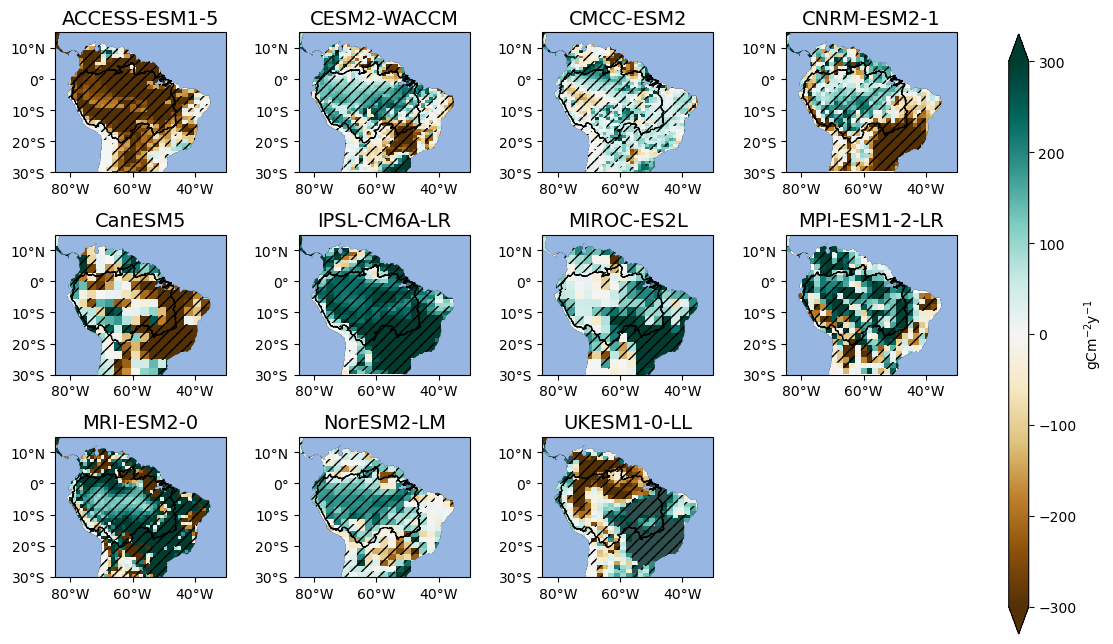

In [31]:
#### ------- Choose between the following plots:
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS'

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# nino_effect       # nina_effect
# nino_hist         # nina_hist
# nino_ssp          # nina_ssp
# msc
# clim_hist         # clim_ssp

# Set shapefiles of amazon and cerrado 

import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

# reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')
# amz = [region for region in reader.records() if region.attributes["ID"] == 1][0]
# cer = [region for region in reader.records() if region.attributes["ID"] == 3][0]
# amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)
# cer = ShapelyFeature([cer.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='cyan', lw=0.7)

plots = ["msc_net"] #,"nina_effect","nina_ssp","nina_hist","nino_effect","nino_ssp","nino_hist","msc_net"] #,"nino_effect","nina_effect","msc","nino_ssp","nina_ssp"]

for to_plot in plots:

    if to_plot == "nina_effect":
        data_plot = nina_effect
        title = 'Composite NEP Nina effect ssp585 - DJF'
        hatch_plot = mannwhitney_nina_effect

    if to_plot == "nino_effect":
        data_plot = nino_effect
        title = 'Composite NEP Nino effect ssp585 - DJF'
        hatch_plot = mannwhitney_nino_effect

    if to_plot == "msc_net":
        data_plot = msc_net
        title = 'Composite NEP mean state change ssp585 - DJF'
        hatch_plot = mannwhitney_msc
    
    if to_plot == "msc_eco2":
        data_plot = msc_eco2
        title = 'Composite NEP eco2 ssp585 - DJF'
        hatch_plot = None

    if to_plot == "ms_ssp":
        data_plot = ms_ssp
        title = 'Composite NEP mean state ssp585 - DJF'

    if to_plot == "ms_hist":
        data_plot = ms_hist
        title = 'Composite NEP mean state hist - DJF'

    if to_plot == "nino_hist":
        data_plot = nino_anom_hist
        title = 'Composite NEP Nino anomalies hist - DJF'
        hatch_plot = mannwhitney_nino_anom_hist

    if to_plot == "nino_ssp":
        data_plot = nino_anom_ssp
        title = 'Composite NEP Nino anomalies ssp585 - DJF'
        hatch_plot = mannwhitney_nino_anom_ssp

    if to_plot == "nina_hist":
        data_plot = nina_anom_hist
        title = 'Composite NEP Nina anomalies hist - DJF'
        hatch_plot = mannwhitney_nina_anom_hist

    if to_plot == "nina_ssp":
        data_plot = nina_anom_ssp
        title = 'Composite NEP Nina anomalies ssp585 - DJF'
        hatch_plot = mannwhitney_nina_anom_ssp

    #### ------- MULTIMODEL PLOT -------- ####

    # --- Set the area: choose the min and max values for the coordinates                                                                                                                          
    # Set lat-lon limits - CUSTOM
    lon_min = -85
    lon_max = -30
    lat_min = -30 
    lat_max = 15

    # --- Plot configuration
    width_inch = 10
    height_inch = 8

    # --- Colorbar configuration#
    min_value, max_value = None, None                                       #automatic colorbar limits
    cbar_position = "top"
                                    
    if var_name == 'nep':
        cbar_label = 'gCm$^{-2}$y$^{-1}$'
        cmap = "BrBG"   

    # --- Title & Axes labels
    xlabel = 'longitude [deg]'
    ylabel = 'latitude [deg]'

    # Create the figure 
    fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
    gs = gridspec.GridSpec(4, 8)

    # Iteratively create subplots 
    for i,k in enumerate(data_plot.keys()):

        if i < 4:
            ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
        if ((i > 3) and (i < 8)):
            ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
        if ((i > 7) and (i < 12)):
            ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
        if i > 11:
            ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

        lons = data_plot[k].lon
        lats = data_plot[k].lat   
        min_value, max_value = -300,300        
        map1 = ax.pcolormesh(lons, lats, data_plot[k], vmin=min_value, vmax=max_value, transform = ccrs.PlateCarree(), cmap=cmap) 
        # map = ax.contourf(lons, lats, data_plot[k], vmin=min_value, vmax=max_value, transform = ccrs.PlateCarree(), cmap=cmap, norm=colors.TwoSlopeNorm(0)) 
        if to_plot != "msc_eco2": 
            sign = np.ma.masked_greater(hatch_plot[k], 0.05)
            map = ax.pcolor(lons, lats, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha=0)
        else:
            None
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
        ax.add_feature(amz)
        # ax.add_feature(cer)

    ## XtickLabels alternative 1
        # Longitude labels
        ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
        lon_formatter = LONGITUDE_FORMATTER
        ax.xaxis.set_major_formatter(lon_formatter)
        #ax.set_xlabel(xlabel, **xlabel_fontstyle)
        # Latitude labels
        ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
        lat_formatter = LATITUDE_FORMATTER
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_title(k,fontsize=14)  

    # # XtickLabels alternative 2
    #     from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    #     gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),x_inline=False, y_inline=False,linewidth=0, 
    #                             xlocs=[-100,-80,-60, -40],
    #                             ylocs=[-20,0,20])
    #     gl.right_labels = False
    #     gl.top_labels = False
    #     gl.xformatter = LONGITUDE_FORMATTER
    #     gl.yformatter = LATITUDE_FORMATTER

    # --- Plot colorbar
    #fig.subplots_adjust(wspace=0, hspace=0)
    fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
    fig.tight_layout()
    cbar_ax = fig.add_axes([1.02, 0.2, 0.02, 0.75])                     # Left, Bottom, Width, Height    
    clb = fig.colorbar(map1, cax=cbar_ax, extend="both")
    # clb.cmap.set_under('maroon')
    clb.cmap.set_over('darkslategray')
    clb.set_label(cbar_label)
    # clb.ax.set_yticklabels(np.arange(-6,9,2))

    # --- Set plot properties
    # fig.suptitle(title, fontsize = 20, y=1.05)
    #fig.supylabel(ylabel)

    # --- Output file
    output_file = os.path.join(out_path, title) + "_net_colorblind.png"
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()
    plt.close()

## Predictors agreement

In [ ]:
test = [xr.concat([a,b], dim = "effects") for a,b in zip(msc, nino_effect)]

hist_importance = []
for i,item in enumerate(msc):
    content = xr.DataArray(data=None, coords=[item.lon, item.lat], dims=["lon", "lat"])

    prova_msc = (np.abs(test[i]).max(dim = "effects") == np.abs(test[i]).sel(effects = 0))
    prova_nino = (np.abs(test[i]).max(dim = "effects") == np.abs(test[i]).sel(effects = 1))

    content = xr.where(prova_msc, 900, None).astype("float64")
    content = xr.where(prova_nino, 901, content).astype("float64")

    hist_importance.append(content)

In [ ]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

seas = "DJF"

# --- Define data to plot
to_plot = "hist_importance"

if to_plot == "hist_importance":
    data_plot = hist_importance.copy()
    cbar_label = 'predictors'
    cmap = colors.ListedColormap(['royalblue', 'yellow'])
    bounds = np.arange(899.5,901.5,1)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    title = 'Predictors agreement historical - Ridge Regression'

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    map = data_plot[i].plot.pcolormesh(ax = ax, x = "lon", y = "lat", cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False, norm = norm)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.add_feature(amz)
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.3, 0.02, 0.5])                     # Left, Bottom, Width, Height
# bounds = np.arange(899.5,901.5,1)
clb = plt.colorbar(map, cax=cbar_ax, ticks=bounds)
clb.set_label(cbar_label, **cbar_fontstyle)
clb.ax.set_yticklabels(['$DeltaMS$', '$DeltaEN$'])

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

## Barplot drivers

In [16]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [17]:
import xarray as xr
import pandas as pd

# Process nino_effect (dictionary version)
nino_effect_amz = {k: zonal_stat(a, geodf).sel(region=1).rename("\u0394EN") for k, a in nino_effect.items()}

# Process nina_effect (dictionary version)
nina_effect_amz = {k: zonal_stat(a, geodf).sel(region=1).rename("\u0394LN") for k, a in nina_effect.items()}

# Process msc (dictionary version)
msc_amz = {k: zonal_stat(a, geodf).sel(region=1).rename("\u0394MS") for k, a in msc_net.items()}

# Process msc_eco2 (dictionary version)
msc_eco2_amz = {k: zonal_stat(a, geodf).sel(region=1).rename("eCO2") for k, a in msc_eco2.items()}


# Concatenate the nino_effect dictionary values, and drop unnecessary columns
df_nino_effect = xr.concat(list(nino_effect_amz.values()), dim="esm").assign_coords(esm=list(nino_effect_amz.keys())).to_dataframe()
df_nino_effect = df_nino_effect.drop(columns=["region", "quantile"])

# Concatenate the nina_effect dictionary values, and drop unnecessary columns
df_nina_effect = xr.concat(list(nina_effect_amz.values()), dim="esm").assign_coords(esm=list(nina_effect_amz.keys())).to_dataframe()
df_nina_effect = df_nina_effect.drop(columns=["region", "quantile"])

# Concatenate the msc dictionary values, and drop unnecessary columns
df_msc = xr.concat(list(msc_amz.values()), dim="esm").assign_coords(esm=list(msc_amz.keys())).to_dataframe()
df_msc = df_msc.drop(columns="region")

# Concatenate the msc dictionary values, and drop unnecessary columns
df_msc_eco2 = xr.concat(list(msc_eco2_amz.values()), dim="esm").assign_coords(esm=list(msc_eco2_amz.keys())).to_dataframe()
df_msc_eco2 = df_msc_eco2.drop(columns="region")

# Concatenate all dataframes along the columns (axis=1)
df_amz = pd.concat([df_nino_effect, df_nina_effect, df_msc, df_msc_eco2], axis=1)

print(df_amz)

                      ΔEN         ΔLN         ΔMS        eCO2
esm                                                          
ACCESS-ESM1-5 -208.194606  139.011002 -352.481302  291.102441
CESM2-WACCM     -7.346173  -14.491168   88.378332   93.634814
CMCC-ESM2       15.377898    7.156815   53.119538  -18.747509
CNRM-ESM2-1    -18.523669    8.336630   35.542185  -10.083962
CanESM5          8.113962  -72.013630 -103.371239  203.292999
IPSL-CM6A-LR   -48.362065    3.662772  267.744557 -182.209662
MIROC-ES2L      19.724158    2.787688  116.581396   -8.341099
MPI-ESM1-2-LR   -1.866828   10.370280  150.738077  -96.604140
MRI-ESM2-0     -32.937211   -9.374951  201.880442 -112.647789
NorESM2-LM     -15.018621  -33.737681  119.732818   92.915621
UKESM1-0-LL    -50.456169   25.829465   17.749562  -23.175191


Text(0.5, 1.0, 'a) Zonal mean ENSO impacts')

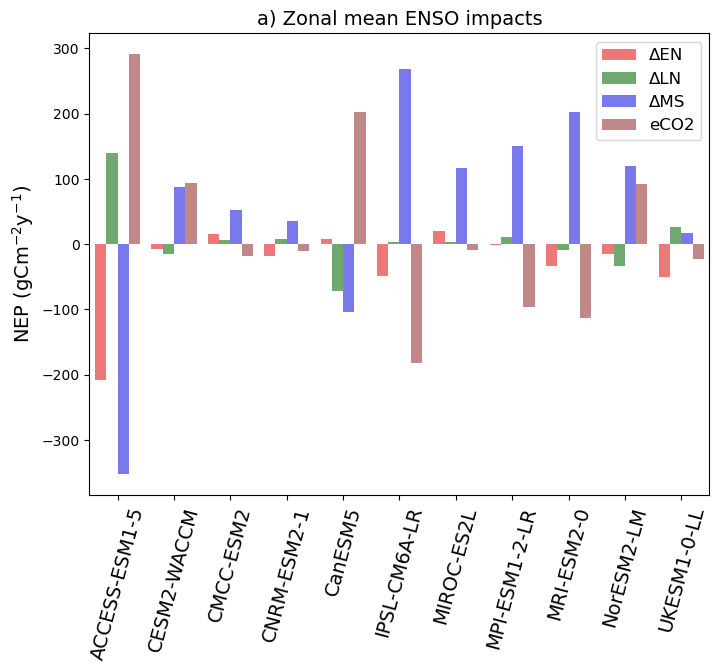

In [18]:
import seaborn as sns

df_amz["esm"] = df_amz.index
df = pd.melt(df_amz, id_vars="esm", var_name="effect")

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax = sns.barplot(
    data=df,
    x="esm", y="value", hue="effect",
    palette=['red', 'green', 'blue', 'brown'], alpha=.6#, height=6
)

# ax.set_ylim(-130, 120)
ax.set_xticklabels(df_amz.index, rotation = 75, fontsize = 14)
ax.legend(loc='upper right', fontsize = 12)
ax.set_xlabel("")
ax.set_ylabel("NEP (gCm$^{-2}$y$^{-1}$)", fontsize = 14)
ax.set_title("")

title = 'Composite analysis, zonal means in the Amazon Basin - ssp585'
ax.set_title("a) Zonal mean ENSO impacts", y = 1.0, fontsize = 14)
# output_file = os.path.join(out_path, title) + ".png"

# g.despine(left=True)
# g.fig.suptitle("Composite analysis, zonal means in the Amazon Basin - ssp585")
# g.set_xticklabels(rotation = 75)
# g.set_axis_labels("", "NEP (gCm$^{-2}$y$^{-1}$)")
# g.fig.set_figwidth(8,6)